# Compressor Module Test

## 1. Compress the Structured Array


**Step 1. Create a Structured Array.**

We first create a random 3D array with shape (255, 255, 100) 

to simulate a structured array with dimensions (longitude, latitude, time).

 The array is cast to float32 type.

In [2]:
import scicodec as sc
import numpy as np

# Create a Structured Array. (lon, lat, time)
example_array = np.random.rand(100,255, 255).astype(np.float32)


**Step 1. Select the proper compressor and error bound.**


**i. Available Compression Methods**



| Compression Method| Mode| Explanation| Supported Error Mode| Extended Package| Reference |
|---|---|---|---|---|---|
|SZ3|Lossy|Prediction-based lossy compressor|abs_precision|libpressio|https://github.com/szcompressor/sz3|
|MGARD|Lossy|Prediction-based lossy compressor|abs_precision|libpressio|https://github.com/LLNL/mgard|
|ZFP|Lossy|Prediction-based lossy compressor|fixed_ratio,bit_precision[0-64]|libpressio|https://github.com/LLNL/zfp|
|MBT2018|Lossy|Deep learning based compressor|level[1-8]|None|https://github.com/mbt2018/compression|
|bmshj2018_factorized|Lossy|Deep learning based compressor|level[1-8]|None|https://github.com/InterDigitalInc/CompressAI|
|cheng2020_anchor|Lossy|Deep learning based compressor|level[1-6]|None|https://github.com/cheng2020/compression|
|Zlib|Lossless|General purpose compressor|level[0-9]|numcodecs|Built-in|
|Blosc|Lossless|High-performance compressor|level[0-9]|numcodecs|None|
|LZ4|Lossless|Fast compression|level[0-12]|numcodecs|None|
|Zstd|Lossless||level[0-9]|numcodecs|https://numcodecs.readthedocs.io/en/stable/compression/zstd.html|
|GZip|Lossless|gzip compression using zlib|level[0-9]|numcodecs||
|FPZip|Lossy|Floating-point compressor|rel_precision,bit_precision[0-64]|FPZip,numcodecs|https://github.com/LLNL/fpzip|




**ii. Error Bound**

SkyShrink supports multiple error bounds for lossy compression. The error bound determines how much error is allowed during compression.
**Supported Error Bounds**

|Error Bound| Parameter in Code|Formula| Range|
|---|---|---|---|
|Absolute Error| abs_precision|max(\|x - x'\|) ≤ ε|0 < ε < 1|
|Relative Error|rel_precision|max(\|x - x'\|/\|x\|) ≤ ε|0 < ε < 1|
|Bit Precision|bit_precision||0<bit_precision<64|
|Mean Absolute Error| mae|mean(\|x - x'\|) ≤ ε|0 < ε < 1|
|Fixed Ratio|fixed_ratio|size(x')/size(x) ≤ ratio|0 < ratio < 1|
|Level of Detail|level|1 is fastest; 9 is slowest and produces the most compression; 0 is no compression.|
1 (Z_BEST_SPEED) is fastest and produces the least compression, 9 (Z_BEST_COMPRESSION) is slowest and produces the most. 0 (Z_NO_COMPRESSION) is no compression. 
Where x is the original data, x' is the compressed data, and ε is the error bound.


In [3]:
# Encode and Decode the Single Structured Array.
print("Available compressors:", sc.compression.supported_compressors)
# Supported Error Bounds
print(sc.compression.supported_error_bounds['sz3'])

Available compressors: ['zlib', 'gzip', 'bz2', 'lzma', 'lz4', 'blosc', 'fpzip', 'zstd', 'sz3', 'mgard', 'zfp', 'mbt2018', 'cheng2020_anchor', 'bmshj2018_factorized']
['abs_precision']


In [7]:
# Initialize compressor with SZ3 method and absolute tolerance of 1e-3

#compressor = sc.compression.Compressor(method='sz3', abs_precision=1e-3)
compressor = sc.compression.Compressor(method='zlib', level=1)
compressor = sc.compression.Compressor(method='LZ4', level=1)
compressor = sc.compression.Compressor(method='gzip', level=1)
compressor = sc.compression.Compressor(method='zstd', level=1)
compressor = sc.compression.Compressor(method='blosc', level=1)
compressor = sc.compression.Compressor(method='fpzip', rel_precision=0.0001)
compressor = sc.compression.Compressor(method='sz3', abs_precision=1)
compressor = sc.compression.Compressor(method='mgard', abs_precision=1)

compressor = sc.compression.Compressor(method='cheng2020_anchor', level=5)
compressor = sc.compression.Compressor(method='mbt2018', level=5)
compressor = sc.compression.Compressor(method='bmshj2018_factorized', level=5)
compressor = sc.compression.Compressor(method='zfp', bit_precision=5)

**Step 2. Encode the Structured Array.**


In [8]:
# Initialize compressor with SZ3 method and absolute tolerance of 1e-3
bitstrings = compressor.encode(example_array)
len(bitstrings)

1414904

**Step 3. Decode**

In [29]:
# Decode the bitstrings back to array
decompressed_array= compressor.decode(bitstrings)
decompressed_array.shape



{'quality': 5, 'pretrained': True, 'device': 'cpu'}


(100, 255, 255)

**Step 4. Check the efficiency metrics.**

|Metric| Unit| Explanation|
|---|---|---|
|Compression Ratio| >1 | Higher values mean better compression. Ratio of original size to compressed size|
|Encoding Speed |(MB/s)| Speed of compression in megabytes per second|
|Decoding Speed| (MB/s)| Speed of decompression in megabytes per second|
 |Bitrate |(bits/byte)| Number of bits needed to represent each byte of original data after compression|


In [6]:
compressor.efficiency_metrics 

{'encoding_speed': 33.65233617532337,
 'compression_ratio': 765000.0,
 'original_bits': 26010000,
 'decoding_speed': 4.0303783843694816e-05}

## 2. Compress the Xarray


In [7]:
import xarray as xr

# Load a example Xarray dataset.
example_ds=sc.dataset.download_benchmark("wrf_short")
example_ds

Dataset wrf_short already exists at ./datasets/wrf_short.nc, reloaded


<xarray.Dataset> Size: 103MB
Dimensions:    (time: 21, latitude: 335, longitude: 525)
Coordinates:
  * time       (time) datetime64[ns] 168B 2022-04-03T18:00:00 ... 2022-04-03T...
  * latitude   (latitude) float32 1kB 34.21 34.21 34.21 ... 34.66 34.66 34.66
  * longitude  (longitude) float32 2kB -120.0 -120.0 -120.0 ... -119.2 -119.2
Data variables:
    T2         (time, latitude, longitude) float32 15MB ...
    U10        (time, latitude, longitude) float32 15MB ...
    V10        (time, latitude, longitude) float32 15MB ...
    PSFC       (time, latitude, longitude) float32 15MB ...
    LAI        (time, latitude, longitude) float32 15MB ...
    ALBEDO     (time, latitude, longitude) float32 15MB ...
    RAINC      (time, latitude, longitude) float32 15MB ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4.1 MODEL
    START_DATE:                      2022-04-03_18:00:00
    SIMULATION_START_DATE:           2022-04-03_18:00:00
    WEST-EAST_GRID_DIMENSION:        526
    SOUTH-NORTH_GRID_DIMENSION:      336
    BOTTOM-TOP_GRID_DIMENSION:       91
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2



**Step 1. Create Encoding Dictionary**
The compressor can be initialized with different modes and parameters for different variables:

- compressor: Compression method ('SZ3', 'ZFPY', etc.)
- abs_tol: Absolute error tolerance



The encoding dictionary specifies compression parameters for each variable:
```python
encode_dict = {
    "var1": {"compressor": "SZ3", "abs_tol": 1e-3},
    "var2": {"compressor": "ZFPY", "abs_tol": 1e-4}
}



In [8]:
# Compress the Xarray dataset.
encode_dict = {
    "T2": {"compressor": "zlib", "level": 1},
    'U10': {'compressor': "fpzip", 'rel_precision': 1e-4},
    'V10': {'compressor': "fpzip", 'rel_precision': 1e-4},    
    "PSFC": {"compressor": "zlib", "level": 1},
    'LAI': {'compressor': "fpzip", 'rel_precision': 1e-4},
    'ALBEDO': {'compressor': "fpzip", 'rel_precision': 1e-4},     
    'RAINC': {'compressor': "fpzip", 'rel_precision': 1e-4},     
}


# Compress the Xarray dataset.
encode_dict = {
    "T2": {"compressor": "zlib", "level": 1},
    'U10': {'compressor': "sz3", 'abs_precision': 1},
    'V10': {'compressor': "bmshj2018_factorized", 'level': 1},    
    "PSFC": {"compressor": "zlib", "level": 1},
    'LAI': {'compressor': "cheng2020_anchor", 'level': 1},
    'ALBEDO': {'compressor': "mbt2018", 'level': 1},     
    'RAINC': {'compressor': "fpzip", 'rel_precision': 1e-4},     
}



compressor = sc.compression.Compressor(method=encode_dict)


**Step 2. Compress and Decompress**

In [9]:
# Encode the dataset to get compressed bitstrings and efficiency metrics
saved_dir="./datasets/Output"
compressor.encode(example_ds, save_dir=saved_dir)


Processing variables: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


'./datasets/Output'

The structure under the given save directory:
```
saved_dir/
├── variable1/
│   └── bin
├── variable2/
│   └── bin 
├── meta.nc
── efficiency_metrics.pkl
└── encoding_list.yaml
```

In [10]:

# During decoding, the compressor will automatically detect the compression method and error bound. 
# So we don't need to specify the compressor.
# We could clarify the compressor.
compressor = sc.compression.Compressor(method=encode_dict)  # or
compressor = sc.compression.Compressor()  # or
compressor = sc.compression.Compressor(method=None)

decompressed_ds = compressor.decode(saved_dir)


# Check the efficiency performance of the compressor
print("\nCompression Results:")
compressor.efficiency_metrics  # (its a dataframe)




Compression Results:


,variable,method,encoding_speed,decoding_speed,compression_ratio,original_bits
0,T2,zlib,52.997772,1.219721e+02,1.447572e+00,14773500
1,U10,sz3,248.906973,5.624439e+00,1.109830e+02,14773500
2,V10,bmshj2018_factorized,41.559505,1.459105e-05,2.110500e+06,14773500
3,PSFC,zlib,47.392278,1.217060e+02,1.426980e+00,14773500
4,LAI,cheng2020_anchor,3.252694,3.268071e-07,2.110500e+06,14773500
5,ALBEDO,mbt2018,2.793920,5.123799e-07,2.110500e+06,14773500
6,RAINC,fpzip,446.073251,1.251549e-02,2.647581e+04,14773500


2. (Optional) Encode and Decode use single method for all variable.

In [11]:

compressor=sc.compression.Compressor(method='zlib',level=5)

# Compress the Xarray dataset.
compressor.encode(example_ds, save_dir=saved_dir)

# Decode the Xarray dataset.
decompressed_ds = compressor.decode(saved_dir)

# Check the efficiency performance of the compressor.
print(decompressed_ds["T2"].attrs["encoding_speed"])
# or
compressor.efficiency_metrics

Processing variables: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


23.88225941838571


,variable,method,encoding_speed,decoding_speed,compression_ratio,original_bits
0,T2,zlib,23.882259,128.377970,1.445869,14773500
1,U10,zlib,26.474620,175.943204,1.127700,14773500
2,V10,zlib,27.178690,179.016489,1.118393,14773500
3,PSFC,zlib,24.469109,133.017528,1.398495,14773500
4,LAI,zlib,38.120857,136.183765,2.012842,14773500
5,ALBEDO,zlib,60.880351,99.346790,3.556420,14773500
6,RAINC,zlib,430.591887,1.033761,1027.650250,14773500


# Find the optimal compression parameters for each variable.

In [1]:
import scicodec as sc
example_ds = sc.dataset.download_benchmark("wrf")
compressor=sc.compression.Compressor(method="sz3", abs_precision=0.0001)
config=compressor.find_config_with_rate(example_ds, compression_rate=100)
print(config)


{'T2': {'abs_precision': 0.72265625, 'compression_rate': 100.25322664538045}, 'U10': {'abs_precision': 1.07421875, 'compression_rate': 99.92056462868702}, 'V10': {'abs_precision': 1.19140625, 'compression_rate': 100.04473330080002}, 'PSFC': {'abs_precision': 9.990234375, 'compression_rate': 18.34971023180687}, 'LAI': {'abs_precision': 0.048828125, 'compression_rate': 178.12729148501174}, 'ALBEDO': {'abs_precision': 0.009765625, 'compression_rate': 849.2306243919788}, 'RAINC': {'abs_precision': 0.009765625, 'compression_rate': 1663604.5081967213}}

Dataset wrf already exists at ./datasets/wrf.nc, reloaded


Finding optimal configs:   0%|          | 0/7 [00:00<?, ?it/s]

Variable: T2, Compression Rate: 5144.538230485533, Absolute Precision: 5.0
Variable: T2, Compression Rate: 696.8000920095855, Absolute Precision: 2.5
Variable: T2, Compression Rate: 192.59743044952424, Absolute Precision: 1.25
Variable: T2, Compression Rate: 86.0904166817779, Absolute Precision: 0.625
Variable: T2, Compression Rate: 133.95661914883718, Absolute Precision: 0.9375
Variable: T2, Compression Rate: 109.08582995037492, Absolute Precision: 0.78125
Variable: T2, Compression Rate: 97.38423492392207, Absolute Precision: 0.703125
Variable: T2, Compression Rate: 103.22229311332623, Absolute Precision: 0.7421875


Finding optimal configs:  14%|█▍        | 1/7 [00:15<01:35, 15.95s/it]

Variable: T2, Compression Rate: 100.25322664538045, Absolute Precision: 0.72265625
Variable: U10, Compression Rate: 1645.250524882256, Absolute Precision: 5.0
Variable: U10, Compression Rate: 350.07002789041843, Absolute Precision: 2.5
Variable: U10, Compression Rate: 120.53086261388862, Absolute Precision: 1.25
Variable: U10, Compression Rate: 55.67369894525422, Absolute Precision: 0.625
Variable: U10, Compression Rate: 85.29510710336056, Absolute Precision: 0.9375
Variable: U10, Compression Rate: 102.08249347963364, Absolute Precision: 1.09375
Variable: U10, Compression Rate: 93.4526648960858, Absolute Precision: 1.015625
Variable: U10, Compression Rate: 97.70873316206041, Absolute Precision: 1.0546875


Finding optimal configs:  29%|██▊       | 2/7 [00:32<01:20, 16.16s/it]

Variable: U10, Compression Rate: 99.92056462868702, Absolute Precision: 1.07421875
Variable: V10, Compression Rate: 971.3641998056886, Absolute Precision: 5.0
Variable: V10, Compression Rate: 267.2543258028602, Absolute Precision: 2.5
Variable: V10, Compression Rate: 105.73491220438495, Absolute Precision: 1.25
Variable: V10, Compression Rate: 52.089852539800496, Absolute Precision: 0.625
Variable: V10, Compression Rate: 77.08804269777336, Absolute Precision: 0.9375
Variable: V10, Compression Rate: 91.02728063512865, Absolute Precision: 1.09375
Variable: V10, Compression Rate: 98.24738854576162, Absolute Precision: 1.171875


Finding optimal configs:  43%|████▎     | 3/7 [00:48<01:04, 16.16s/it]

Variable: V10, Compression Rate: 102.00579135879812, Absolute Precision: 1.2109375
Variable: V10, Compression Rate: 100.04473330080002, Absolute Precision: 1.19140625
Variable: PSFC, Compression Rate: 18.535765001718325, Absolute Precision: 5.0
Variable: PSFC, Compression Rate: 19.50120251638462, Absolute Precision: 7.5
Variable: PSFC, Compression Rate: 20.315630372385282, Absolute Precision: 8.75
Variable: PSFC, Compression Rate: 20.335556126444512, Absolute Precision: 9.375
Variable: PSFC, Compression Rate: 20.49222597432219, Absolute Precision: 9.6875
Variable: PSFC, Compression Rate: 20.839050021122976, Absolute Precision: 9.84375
Variable: PSFC, Compression Rate: 20.582979955909206, Absolute Precision: 9.921875
Variable: PSFC, Compression Rate: 20.022335744086295, Absolute Precision: 9.9609375
Variable: PSFC, Compression Rate: 19.956168349995203, Absolute Precision: 9.98046875


Finding optimal configs:  57%|█████▋    | 4/7 [01:16<01:02, 20.73s/it]

Variable: PSFC, Compression Rate: 18.34971023180687, Absolute Precision: 9.990234375
Variable: LAI, Compression Rate: 3657.9210597458773, Absolute Precision: 5.0
Variable: LAI, Compression Rate: 932.3402476474412, Absolute Precision: 2.5
Variable: LAI, Compression Rate: 872.2829765790701, Absolute Precision: 1.25
Variable: LAI, Compression Rate: 292.11058650310986, Absolute Precision: 0.625
Variable: LAI, Compression Rate: 462.15813724720005, Absolute Precision: 0.3125
Variable: LAI, Compression Rate: 283.8413305987792, Absolute Precision: 0.15625
Variable: LAI, Compression Rate: 235.72670488596927, Absolute Precision: 0.078125
Variable: LAI, Compression Rate: 36.92962101875914, Absolute Precision: 0.0390625
Variable: LAI, Compression Rate: 124.439337127953, Absolute Precision: 0.05859375


Finding optimal configs:  71%|███████▏  | 5/7 [01:30<00:37, 18.54s/it]

Variable: LAI, Compression Rate: 178.12729148501174, Absolute Precision: 0.048828125
Variable: ALBEDO, Compression Rate: 1663604.5081967213, Absolute Precision: 5.0
Variable: ALBEDO, Compression Rate: 1663604.5081967213, Absolute Precision: 2.5
Variable: ALBEDO, Compression Rate: 1663604.5081967213, Absolute Precision: 1.25
Variable: ALBEDO, Compression Rate: 270432.7115256496, Absolute Precision: 0.625
Variable: ALBEDO, Compression Rate: 49928.59778597786, Absolute Precision: 0.3125
Variable: ALBEDO, Compression Rate: 2671.858955793686, Absolute Precision: 0.15625
Variable: ALBEDO, Compression Rate: 280.1367145040907, Absolute Precision: 0.078125
Variable: ALBEDO, Compression Rate: 660.3441628477865, Absolute Precision: 0.0390625
Variable: ALBEDO, Compression Rate: 1333.6646252513438, Absolute Precision: 0.01953125


Finding optimal configs:  86%|████████▌ | 6/7 [01:44<00:16, 16.80s/it]

Variable: ALBEDO, Compression Rate: 849.2306243919788, Absolute Precision: 0.009765625
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 5.0
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 2.5
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 1.25
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.625
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.3125
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.15625
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.078125
Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.0390625
Variable: RAINC, Compression Rate: 1656814.2857142857, Absolute Precision: 0.01953125


Finding optimal configs: 100%|██████████| 7/7 [01:56<00:00, 16.65s/it]

Variable: RAINC, Compression Rate: 1663604.5081967213, Absolute Precision: 0.009765625
{'T2': {'abs_precision': 0.72265625, 'compression_rate': 100.25322664538045}, 'U10': {'abs_precision': 1.07421875, 'compression_rate': 99.92056462868702}, 'V10': {'abs_precision': 1.19140625, 'compression_rate': 100.04473330080002}, 'PSFC': {'abs_precision': 9.990234375, 'compression_rate': 18.34971023180687}, 'LAI': {'abs_precision': 0.048828125, 'compression_rate': 178.12729148501174}, 'ALBEDO': {'abs_precision': 0.009765625, 'compression_rate': 849.2306243919788}, 'RAINC': {'abs_precision': 0.009765625, 'compression_rate': 1663604.5081967213}}


In [1]:
import scicodec as sc
example_ds = sc.dataset.download_benchmark("wrf")
compressor=sc.compression.Compressor(method="bmshj2018_factorized", level=1)
config=compressor.find_config_with_rate(example_ds, compression_rate=100)
print(config)


Dataset wrf already exists at ./datasets/wrf.nc, reloaded


/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
Finding optimal configs:   0%|          | 0/7 [00:00<?, ?it/s]

Variable: T2, Compression Rate: 565.0106900065142, Level: 3
Variable: T2, Compression Rate: 270.0117737837083, Level: 5


Finding optimal configs:  14%|█▍        | 1/7 [00:36<03:38, 36.40s/it]

Variable: T2, Compression Rate: 188.64814697768492, Level: 6
Variable: U10, Compression Rate: 510.59313505979907, Level: 3
Variable: U10, Compression Rate: 242.95500251382603, Level: 5


Finding optimal configs:  29%|██▊       | 2/7 [01:13<03:03, 36.77s/it]

Variable: U10, Compression Rate: 171.3564752665839, Level: 6
Variable: V10, Compression Rate: 499.60306910659165, Level: 3
Variable: V10, Compression Rate: 245.05417616490226, Level: 5


Finding optimal configs:  43%|████▎     | 3/7 [01:52<02:30, 37.72s/it]

Variable: V10, Compression Rate: 174.92368195153566, Level: 6
Variable: PSFC, Compression Rate: 559.1146880733439, Level: 3
Variable: PSFC, Compression Rate: 287.12538974744933, Level: 5


Finding optimal configs:  57%|█████▋    | 4/7 [02:31<01:54, 38.13s/it]

Variable: PSFC, Compression Rate: 207.8368495106161, Level: 6
Variable: LAI, Compression Rate: 234.630124158979, Level: 3
Variable: LAI, Compression Rate: 120.79715147871941, Level: 5


Finding optimal configs:  71%|███████▏  | 5/7 [03:08<01:15, 37.90s/it]

Variable: LAI, Compression Rate: 88.04744485965577, Level: 6
Variable: ALBEDO, Compression Rate: 259.4431093328561, Level: 3
Variable: ALBEDO, Compression Rate: 131.17704657385505, Level: 5


Finding optimal configs:  86%|████████▌ | 6/7 [03:45<00:37, 37.53s/it]

Variable: ALBEDO, Compression Rate: 95.15581925248017, Level: 6
Variable: RAINC, Compression Rate: 707.2507579189462, Level: 3
Variable: RAINC, Compression Rate: 366.537269604603, Level: 5


Finding optimal configs: 100%|██████████| 7/7 [04:23<00:00, 37.62s/it]

Variable: RAINC, Compression Rate: 265.46718410334086, Level: 6
{'T2': {'level': 6, 'compression_rate': 188.64814697768492}, 'U10': {'level': 6, 'compression_rate': 171.3564752665839}, 'V10': {'level': 6, 'compression_rate': 174.92368195153566}, 'PSFC': {'level': 6, 'compression_rate': 207.8368495106161}, 'LAI': {'level': 6, 'compression_rate': 88.04744485965577}, 'ALBEDO': {'level': 6, 'compression_rate': 95.15581925248017}, 'RAINC': {'level': 6, 'compression_rate': 265.46718410334086}}


In [1]:
import scicodec as sc
example_ds = sc.dataset.download_benchmark("wrf")
compressor=sc.compression.Compressor(method="zfp", bit_precision=15)
config=compressor.find_config_with_rate(example_ds, compression_rate=100)
print(config)



Dataset wrf already exists at ./datasets/wrf.nc, reloaded


Finding optimal configs:   0%|          | 0/7 [00:00<?, ?it/s]

Variable: T2, Compression Rate: 14.590827292874842, Bit Precision: 16
Variable: T2, Compression Rate: 87.81741691170998, Bit Precision: 7


Finding optimal configs:  14%|█▍        | 1/7 [00:05<00:33,  5.51s/it]

Variable: T2, Compression Rate: 134.6533415247108, Bit Precision: 3
Variable: T2, Compression Rate: 106.30528447278883, Bit Precision: 5
Variable: T2, Compression Rate: 96.180885305006, Bit Precision: 6
Variable: U10, Compression Rate: 3.6065673369128, Bit Precision: 16
Variable: U10, Compression Rate: 26.830770023954187, Bit Precision: 7


Finding optimal configs:  29%|██▊       | 2/7 [00:11<00:29,  5.82s/it]

Variable: U10, Compression Rate: 137.53679669520952, Bit Precision: 3
Variable: U10, Compression Rate: 65.97948248823838, Bit Precision: 5
Variable: U10, Compression Rate: 101.14609289345161, Bit Precision: 4
Variable: V10, Compression Rate: 3.592215339769547, Bit Precision: 16
Variable: V10, Compression Rate: 26.57481784128833, Bit Precision: 7
Variable: V10, Compression Rate: 136.6092053825278, Bit Precision: 3
Variable: V10, Compression Rate: 64.5517534206492, Bit Precision: 5


Finding optimal configs:  43%|████▎     | 3/7 [00:17<00:23,  5.93s/it]

Variable: V10, Compression Rate: 99.17620999425348, Bit Precision: 4
Variable: PSFC, Compression Rate: 15.27793669313862, Bit Precision: 16
Variable: PSFC, Compression Rate: 87.81741691170998, Bit Precision: 7
Variable: PSFC, Compression Rate: 134.6533415247108, Bit Precision: 3
Variable: PSFC, Compression Rate: 106.30528447278883, Bit Precision: 5


Finding optimal configs:  57%|█████▋    | 4/7 [00:23<00:17,  5.72s/it]

Variable: PSFC, Compression Rate: 96.180885305006, Bit Precision: 6
Variable: LAI, Compression Rate: 9.90500388763097, Bit Precision: 16
Variable: LAI, Compression Rate: 65.64342342388963, Bit Precision: 7


Finding optimal configs:  71%|███████▏  | 5/7 [00:27<00:10,  5.11s/it]

Variable: LAI, Compression Rate: 198.29738195546315, Bit Precision: 3
Variable: LAI, Compression Rate: 123.00829470632158, Bit Precision: 5
Variable: LAI, Compression Rate: 89.1832838260625, Bit Precision: 6
Variable: ALBEDO, Compression Rate: 12.364888328398582, Bit Precision: 16
Variable: ALBEDO, Compression Rate: 59.013788703858346, Bit Precision: 7


Finding optimal configs:  86%|████████▌ | 6/7 [00:31<00:05,  5.00s/it]

Variable: ALBEDO, Compression Rate: 135.23185201768624, Bit Precision: 3
Variable: ALBEDO, Compression Rate: 96.67604245062829, Bit Precision: 5
Variable: ALBEDO, Compression Rate: 117.12063278458456, Bit Precision: 4
Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 16
Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 24
Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 28
Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 30


Finding optimal configs: 100%|██████████| 7/7 [00:33<00:00,  4.81s/it]

Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 31
Variable: RAINC, Compression Rate: 2019.7411631239552, Bit Precision: 32
{'T2': {'bit_precision': 6, 'compression_rate': 96.180885305006}, 'U10': {'bit_precision': 4, 'compression_rate': 101.14609289345161}, 'V10': {'bit_precision': 4, 'compression_rate': 99.17620999425348}, 'PSFC': {'bit_precision': 6, 'compression_rate': 96.180885305006}, 'LAI': {'bit_precision': 6, 'compression_rate': 89.1832838260625}, 'ALBEDO': {'bit_precision': 4, 'compression_rate': 117.12063278458456}, 'RAINC': {'bit_precision': 32, 'compression_rate': 2019.7411631239552}}


# 3. Batch Compression

In [1]:

import scicodec as sc
example_ds = sc.dataset.download_benchmark("wrf")


# Compress the Xarray dataset.
sz3_dict={'T2': {'abs_precision': 0.72265625, 'compressor': 'sz3'}, 
 'U10': {'abs_precision': 1.07421875, 'compressor': 'sz3'}, 
 'V10': {'abs_precision': 1.19140625, 'compressor': 'sz3'}, 
 'PSFC': {'abs_precision': 9.990234375, 'compressor': 'sz3'}, 
 'LAI': {'abs_precision': 0.048828125, 'compressor': 'sz3'}, 
 'ALBEDO': {'abs_precision': 0.009765625, 'compressor': 'sz3'}, 
 'RAINC': {'abs_precision': 0.009765625, 'compressor': 'sz3'}}

    
zfp_dict={'T2': {'bit_precision': 6, 'compressor': 'zfp'}, 
 'U10': {'bit_precision': 4, 'compressor': 'zfp'}, 
 'V10': {'bit_precision': 4, 'compressor': 'zfp'}, 
 'PSFC': {'bit_precision': 6, 'compressor': 'zfp'}, 
 'LAI': {'bit_precision': 6, 'compressor': 'zfp'}, 
 'ALBEDO': {'bit_precision': 4, 'compressor': 'zfp'}, 
 'RAINC': {'bit_precision': 32, 'compressor': 'zfp'}}



batch_dict = {
    "work1": sz3_dict,
    'work2': {'compressor': "bmshj2018_factorized", 'level': 7},   
    'work3': zfp_dict,    
}

saved_dir="./datasets/batch_output"

compressor=sc.compression.BatchCompressor(method= batch_dict)

# Compress the Xarray dataset.
compressor.encode(example_ds, save_dir=saved_dir)

# Decode the Xarray dataset.
decompressed_ds = compressor.decode(saved_dir,output_dir=saved_dir)




Dataset wrf already exists at ./datasets/wrf.nc, reloaded


Batch Decoding:  33%|███▎      | 1/3 [00:47<01:35, 47.59s/it]/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
Batch Decoding: 100%|██████████| 3/3 [04:58<00:00, 99.35s/it] 


# Dataset Module Test

**Dataset Module**

This module provides functionality for downloading and managing benchmark datasets for compression testing.

**Available Datasets**

- **era5**: ERA5 reanalysis data from ECMWF
- **wrf_short**: Short sample of WRF model output
- **wrf**: Full WRF model output dataset
**Usage**


## 1. Downlaoding benchmark dataset

In [13]:

ds = sc.dataset.download_benchmark("wrf")

Dataset wrf already exists at ./datasets/wrf.nc, reloaded


Analyzing bit information: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


ICfilt unique values: [2.93580465e-06 3.03961105e-05 3.39317148e-05 8.25714652e-05
 8.98030105e-05 9.18808257e-05 1.86697244e-04 4.30464111e-04
 5.33887866e-04 1.57200698e-03 1.66099141e-03 2.00786802e-03
 5.27978943e-03 5.90705653e-03 5.98331466e-03 6.55570982e-03
 1.57429949e-02 2.62468151e-02 3.19975472e-02 3.20003760e-02
 3.27676648e-02 3.37563207e-02 3.42012617e-02 3.62215753e-02
 3.94016389e-02 4.47676260e-02 5.53737901e-02 7.11625538e-02
 7.70541434e-02 7.70588682e-02 7.82284645e-02 8.09667775e-02
 8.43688825e-02 8.56161148e-02 9.63673870e-02 9.76888346e-02
 1.17044945e-01 1.18669223e-01 1.45664989e-01 1.55436785e-01
 1.82124627e-01 2.61487897e-01 4.78600044e-01 4.79343318e-01
 4.81833019e-01 4.84718312e-01 1.00000000e+00]


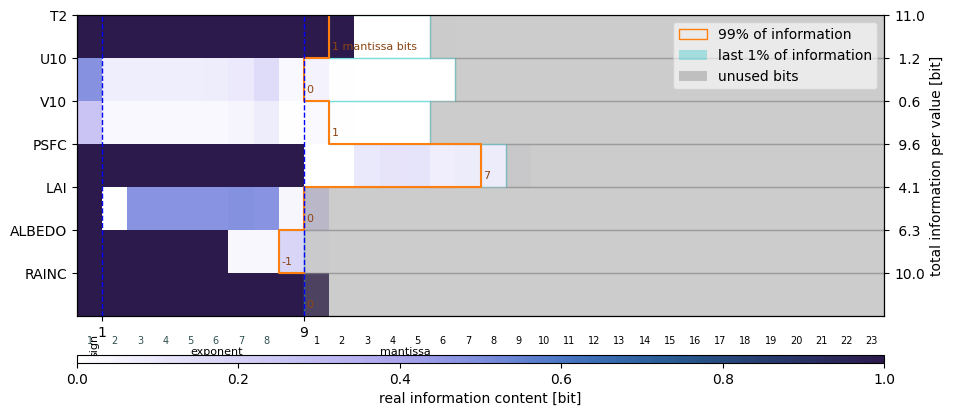

In [14]:
# Diagnoise the datasets w.r.t compression.
from scicodec.dataset import plot_bit_information
import matplotlib.pyplot as plt

# Create the visualization
fig, ax1, ax1right = plot_bit_information(example_ds)

#ds=ss.dataset.diagnose(ds)


# Evaluation Module Test

## 1. Objective Indicator

Define the workspace dir

In [1]:
import scicodec as sc

# Compress the Xarray dataset.
batch_list = ["work1","work2", "work3"]
saved_dir="./datasets/batch_output"
 
# Generate the list of directories
batch_dir = [f"{saved_dir}/{batch}.nc" for batch in batch_list] 
original_ds='./datasets/wrf.nc'
example_ds=sc.dataset.download_benchmark("wrf")


Dataset wrf already exists at ./datasets/wrf.nc, reloaded


Print a table efficiency Metric (Only support this Library generated ds)

In [3]:

# if the data is compressed, then it check the meta information, to extract the method etc,.
# if not, it rank as method1, method2, method3, method4, method5. etc,.

eff_metrics=sc.evaluation.efficiency(batch_dir)
eff_metrics.groupby(['var','method']).mean(numeric_only=1)
		


encoding (MB/s)  decoding (MB/s)  \
var    method                                                   
ALBEDO bmshj2018_factorized        15.535413        15.535413   
       sz3                        279.394509       279.394509   
       zfp                        603.399702       603.399702   
LAI    bmshj2018_factorized        16.372482        16.372482   
       sz3                        263.084359       263.084359   
       zfp                        633.673962       633.673962   
PSFC   bmshj2018_factorized        15.923721        15.923721   
       sz3                        145.185775       145.185775   
       zfp                        501.937355       501.937355   
RAINC  bmshj2018_factorized        16.025448        16.025448   
       sz3                        326.249004       326.249004   
       zfp                       1616.283503      1616.283503   
T2     bmshj2018_factorized        15.449313        15.449313   
       sz3                        226.102342       226.102342   
       zfp                        501.116161       501.116161   
U10    bmshj2018_factorized        15.896968        15.896968   
       sz3                        225.185066       225.185066   
       zfp                        572.796439       572.796439   
V10    bmshj2018_factorized        16.073945        16.073945   
       sz3                        227.626208       227.626208   
       zfp                        580.911969       580.911969   

                             compression_ratio  original_bits  
var    method                                                  
ALBEDO bmshj2018_factorized       7.230857e+01    405919500.0  
       sz3                        8.492306e+02    405919500.0  
       zfp                        1.171206e+02    405919500.0  
LAI    bmshj2018_factorized       6.747772e+01    405919500.0  
       sz3                        1.781273e+02    405919500.0  
       zfp                        8.918328e+01    405919500.0  
PSFC   bmshj2018_factorized       1.497973e+02    405919500.0  
       sz3                        1.834971e+01    405919500.0  
       zfp                        9.618089e+01    405919500.0  
RAINC  bmshj2018_factorized       1.919201e+02    405919500.0  
       sz3                        1.663605e+06    405919500.0  
       zfp                        2.019741e+03    405919500.0  
T2     bmshj2018_factorized       1.310270e+02    405919500.0  
       sz3                        1.002532e+02    405919500.0  
       zfp                        9.618089e+01    405919500.0  
U10    bmshj2018_factorized       1.208674e+02    405919500.0  
       sz3                        9.992056e+01    405919500.0  
       zfp                        1.011461e+02    405919500.0  
V10    bmshj2018_factorized       1.246490e+02    405919500.0  
       sz3                        1.000447e+02    405919500.0  
       zfp                        9.917621e+01    405919500.0

Print a table accuracy metric.

In [2]:

# if the data is compressed, then it check the meta information, to extract the method etc,.
# if not, it rank as method1, method2, method3, method4, method5. etc,.

acc_metrics=sc.evaluation.accuracy(original_ds,batch_dir)
acc_metrics.groupby(['var','method']).mean(numeric_only=1)
		


Computing accuracy:  33%|███▎      | 7/21 [01:32<03:20, 14.33s/it]/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
Computing accuracy:  67%|██████▋   | 14/21 [03:16<01:45, 15.00s/it]/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
Computing accuracy: 100%|██████████| 21/21 [04:55<00:00, 14.30s/it]/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/numpy/

RMSE           SRR          MAE  \
var    method                                                         
ALBEDO bmshj2018_factorized     0.002550  1.727391e-03     0.001429   
       sz3                      0.003055 -2.940372e-03     0.002311   
       zfp                      0.032964 -4.533580e-02     0.020557   
LAI    bmshj2018_factorized     0.060269  7.962319e-04     0.034284   
       sz3                      0.018249 -9.173030e-04     0.013542   
       zfp                      0.239155 -2.953658e-02     0.128248   
PSFC   bmshj2018_factorized   120.920685  6.915485e-04    85.953773   
       sz3                      5.765784 -6.019394e-07     4.992543   
       zfp                   3750.994629 -3.236246e-01  3221.115234   
RAINC  bmshj2018_factorized     0.000000           inf     0.000000   
       sz3                      0.000000           inf     0.000000   
       zfp                      0.000000           inf     0.000000   
T2     bmshj2018_factorized     0.245210  3.420461e-03     0.161820   
       sz3                      0.269990  2.722495e-03     0.210416   
       zfp                      4.357459  3.918763e-01     3.174601   
U10    bmshj2018_factorized     0.316217  7.244949e-03     0.228723   
       sz3                      0.434263  6.634945e-03     0.345786   
       zfp                      1.041228 -5.084201e-02     0.709877   
V10    bmshj2018_factorized     0.354007  1.004656e-02     0.254599   
       sz3                      0.473968  5.024999e-03     0.375747   
       zfp                      1.301760  2.364608e-02     0.799705   

                             Correlation Coefficient  Maximum Error  \
var    method                                                         
ALBEDO bmshj2018_factorized                 0.999304       0.147649   
       sz3                                  0.999003       0.009766   
       zfp                                  0.902202       0.357500   
LAI    bmshj2018_factorized                 0.999696       2.497078   
       sz3                                  0.999972       0.048828   
       zfp                                  0.995656       5.331498   
PSFC   bmshj2018_factorized                 0.999770    1189.687500   
       sz3                                  0.999999       9.984375   
       zfp                                  0.927310    7284.921875   
RAINC  bmshj2018_factorized                      NaN       0.000000   
       sz3                                       NaN       0.000000   
       zfp                                       NaN       0.000000   
T2     bmshj2018_factorized                 0.998115       8.227448   
       sz3                                  0.997711       0.722656   
       zfp                                  0.267444      29.933563   
U10    bmshj2018_factorized                 0.996127       5.138307   
       sz3                                  0.992676       1.074219   
       zfp                                  0.962162      23.408415   
V10    bmshj2018_factorized                 0.995358       4.992403   
       sz3                                  0.991658       1.191406   
       zfp                                  0.938876      31.169363   

                              Mean Error  Peak Error      SSIM      RMSZ  \
var    method                                                              
ALBEDO bmshj2018_factorized    -0.000167   -1.341037  0.999053  0.037380   
       sz3                      0.000090   -1.377642  0.998484  0.044774   
       zfp                     -0.011937   -2.058894  0.881970  0.483194   
LAI    bmshj2018_factorized    -0.003716   -1.000000  0.999200  0.024689   
       sz3                      0.001356   -1.010813  0.999919  0.007476   
       zfp                     -0.042428   -1.780485  0.991024  0.097968   
PSFC   bmshj2018_factorized    -6.673209   -3.052182  0.999300  0.021461   
       sz3                     -0.000600   -3.052206  0.999997  0.001023   
       z

## 2.Compare spatial etc,.

/media/zhehao/Data/Onedrive_Share/Code/SkyShrink/scicodec/evaluation/spatial.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


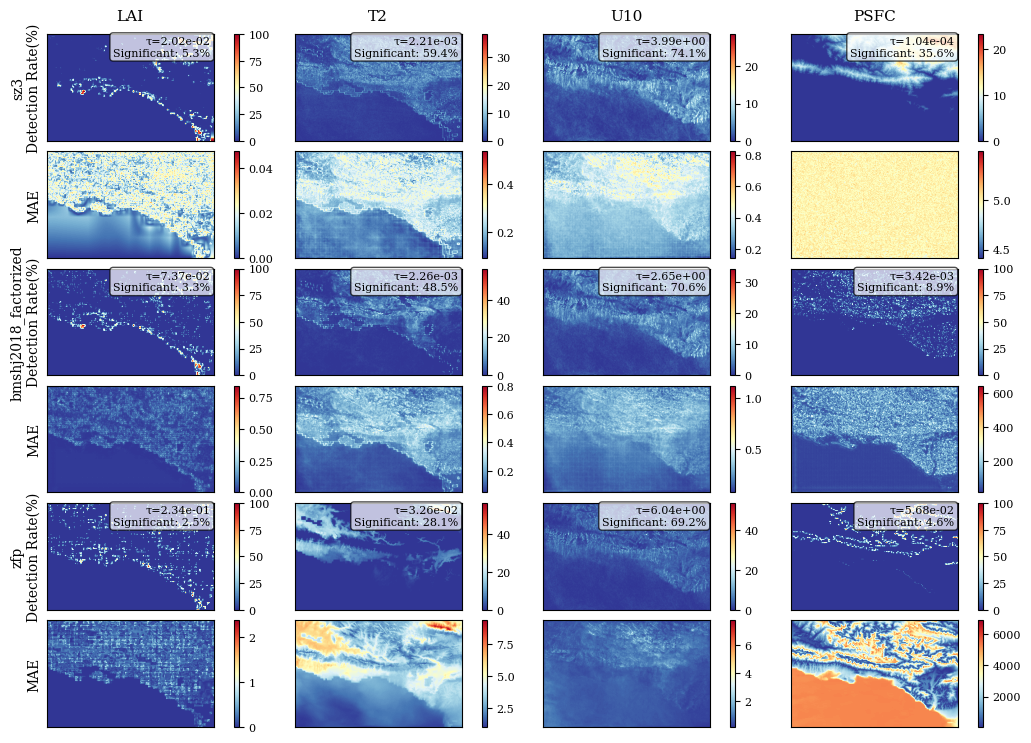

In [3]:

# if the data is compressed, then it check the meta information, to extract the method etc,.
# if not, it rank as method1, method2, method3, method4, method5. etc,.

import scicodec as sc
var_list = ["LAI" , "T2", "U10","PSFC"]

original_ds='./datasets/wrf.nc'
# Compress the Xarray dataset.
batch_list = ["work1","work2", "work3"]
saved_dir="./datasets/batch_output"
# Generate the list of directories
batch_dir = [f"{saved_dir}/{batch}.nc" for batch in batch_list] 


sc.evaluation.plot_spatial_error(batch_dir, var_list, original_ds)



## 3. Time series

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


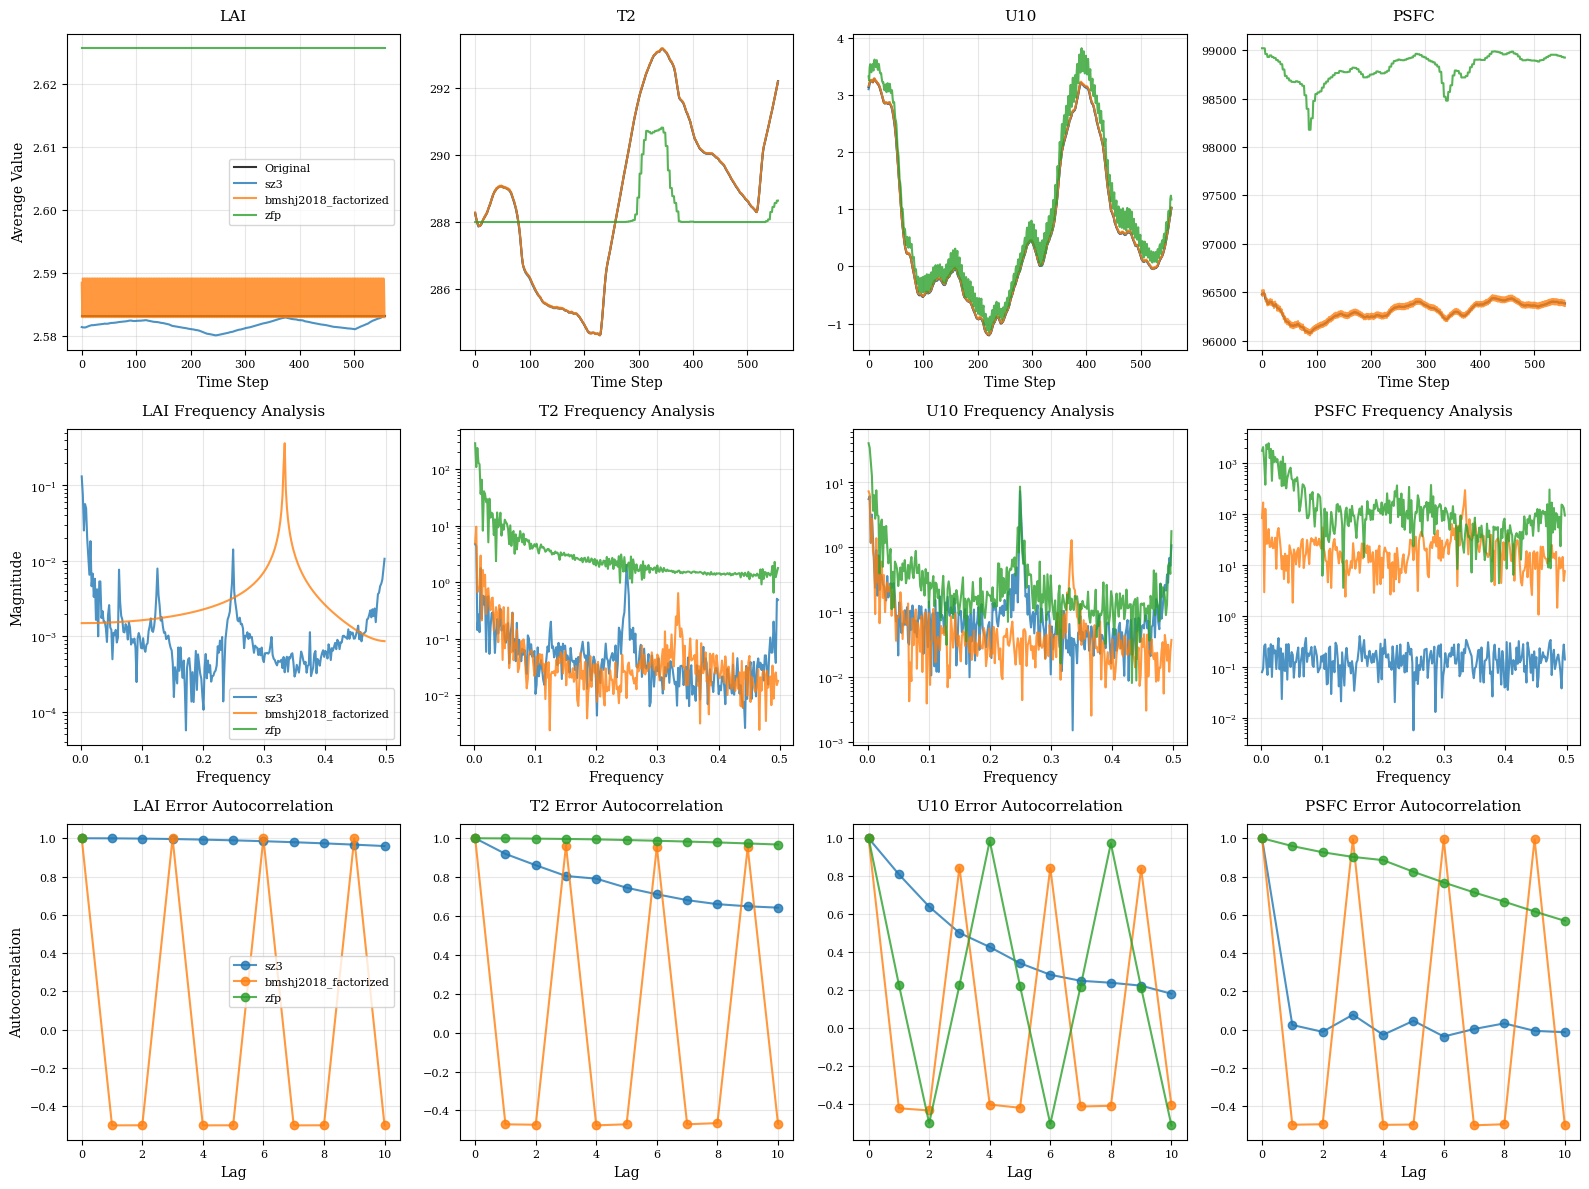

In [5]:
# if the data is compressed, then it check the meta information, to extract the method etc,.
# if not, it rank as method1, method2, method3, method4, method5. etc,.

import scicodec as sc
import xarray as xr


import scicodec as sc
var_list = ["LAI" , "T2", "U10","PSFC"]

original_ds='./datasets/wrf.nc'
# Compress the Xarray dataset.
batch_list = ["work1","work2", "work3"]
saved_dir="./datasets/batch_output"
# Generate the list of directories
batch_dir = [f"{saved_dir}/{batch}.nc" for batch in batch_list] 



sc.evaluation.temporal(batch_dir, var_list, original_ds)

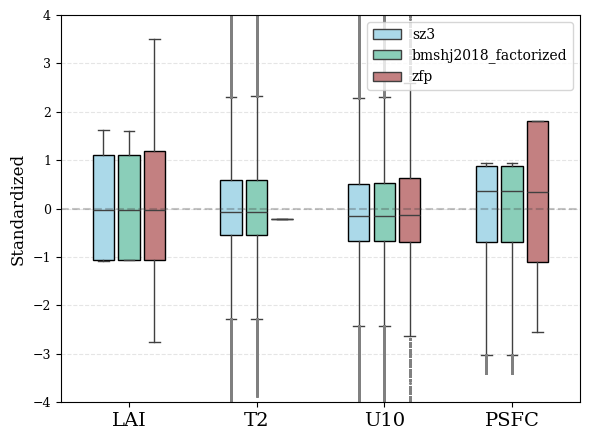

In [8]:
# if the data is compressed, then it check the meta information, to extract the method etc,.
# if not, it rank as method1, method2, method3, method4, method5. etc,.




import scicodec as sc
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr


import scicodec as sc
var_list = ["LAI" , "T2", "U10","PSFC"]

original_ds='./datasets/wrf.nc'
# Compress the Xarray dataset.
batch_list = ["work1","work2", "work3"]
saved_dir="./datasets/batch_output"
# Generate the list of directories
batch_dir = [f"{saved_dir}/{batch}.nc" for batch in batch_list] 


# Create figure for box plots
fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111)

data_to_plot = []
labels = []
methods = []

# Define sophisticated color palette
colors = ['#abd9e9', '#8ACEB9', '#C38081', '#85BFC3', '#2E8B57', 
          '#4682B4', '#CD853F', '#8B4513', '#483D8B', '#6B8E23',
          '#8B008B', '#556B2F', '#B8860B', '#800000']

# Load and prepare data for each variable
for var in var_list:
    var_data = []
    # Get original data mean and std
    with nc.Dataset(original_ds) as ds:
        original_data = ds[var][:].flatten()
        var_mean = np.mean(original_data)
        var_std = np.std(original_data)
    
    # Get data and methods for each model
    for model_path in batch_dir:
        ds_model = xr.open_dataset(model_path)
        data = ds_model[var].values.flatten()
        # Standardize using original stats
        data = (data - var_mean) / var_std
        var_data.append(data)
        # Get compression method from attributes
        method = ds_model[var].attrs.get('method')
        if method not in methods:
            methods.append(method)
        ds_model.close()
    data_to_plot.append(var_data)

num_vars = len(var_list)
num_models = len(methods)
positions = np.arange(num_vars) * 1.5

for j in range(num_vars):
    var_boxes = []
    for i in range(min(num_models, len(colors))):
        pos = positions[j] + i * 0.3
        bp = ax.boxplot([data_to_plot[j][i]], positions=[pos], 
                       widths=0.25,
                       patch_artist=True,
                       whis=1.5,          
                       flierprops={'marker': 'o',    
                                 'markerfacecolor': '#808080',
                                 'markeredgecolor': '#808080',
                                 'markersize': 1},
                       medianprops={'color': '#404040'})
        
        plt.setp(bp['boxes'], facecolor=colors[i], alpha=1)
        plt.setp(bp['whiskers'], color='#404040')
        plt.setp(bp['caps'], color='#404040')
        var_boxes.append(bp)

# Set tick labels
tick_positions = positions + (min(num_models, len(colors)) - 1) * 0.3 / 2
plt.xticks(tick_positions, var_list, fontsize=14)

# Add legend with methods from attributes
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor=colors[i], alpha=1, edgecolor='#404040', label=methods[i])
    for i in range(min(num_models, len(colors)))
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.ylabel('Standardized', fontsize=12)
plt.grid(True, axis='y', alpha=0.2, linestyle='--', color='#808080')
plt.axhline(y=0, color='#404040', linestyle='--', alpha=0.3)
plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

## 2. Tuning

In [ ]:

import pandas as pd
from matplotlib import pyplot as plt
def plot_compression_ratios(df, method_list, var_list, x, y, level,x_lim=None, y_lim=None):
    fig, ax = plt.subplots(figsize=(5, 3))
    colors = ['Reds', 'Blues',  'Purples']  # Add more colors if needed
    markers = ['o', 's', 'D', '^']  # Add more markers if needed
    edge_colors = ['b', 'green', 'purple']  # Edge colors matching the colormaps
    scatter_plots = []
    legend_handles = []
    
    for i, method in enumerate(method_list):
        df_method = df[df["method"] == method]

        for j, var in enumerate(var_list):

            color = colors[j]
            
            cmap = plt.get_cmap(color)
                
            df_var = df_method[df_method["var"] == var]
            marker = markers[j % len(markers)]
            edge_color = edge_colors[j % len(edge_colors)]
            sc = ax.scatter(df_var[x], df_var[y], c=df_var[level],
                            s=50, cmap=color, edgecolor="k", marker=marker, 
                            label=f'{method} {var}')
            scatter_plots.append(sc)
            
            # Create colored proxy artist for legend
            legend_handle = plt.scatter([], [], marker=marker, 
                                      color=cmap(0.7),  # Use a fixed color from colormap
                                      edgecolor='k',
                                      label=var)
            legend_handles.append(legend_handle)
            
        # Create colorbar with 4 integer ticks
        cbar = plt.colorbar(sc, ax=ax, shrink=0.4, label=method+"_"+level)
        levels = np.unique(df_method[level].astype(int))
        tick_indices = np.linspace(0, len(levels)-1, 3, dtype=int)
        cbar.set_ticks(levels[tick_indices])
    ax.legend(handles=legend_handles, labels=var_list)
    ax.set_xlabel(x)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_ylabel(y)
    plt.grid()
    plt.show()

# x = "compression_ratio"
# y = "encoding (MB/s)"

# plot_compression_ratios(pd.read_csv(file_dir+"zfpy_config.csv"), ["zfpy"],["ALBEDO","U10", "T2"], x, y,"precision")

# df=pd.read_csv(file_dir+"sz3_config.csv")
# # Extract precision from workspace_name for SZ3 entries
# df['precision'] = df[df['workspace_name'].str.contains('SZ3_', na=False)]['workspace_name'].str.extract('_(\d+)').astype(int)
# plot_compression_ratios(df, ["SZ3"], ["ALBEDO","U10", "T2"], x, y,"precision")

# # Save the DataFrame to CSV
# df=pd.read_csv(file_dir+"bmshj_config.csv")
# # Extract precision from workspace_name for SZ3 entries
# df['precision'] = df[df['workspace_name'].str.contains('bmshj_', na=False)]['workspace_name'].str.extract('_(\d+)').astype(int)
# plot_compression_ratios(df, ["bmshj2018"], ["ALBEDO","U10", "T2"], x, y,"precision")






